# Segment syllables within identified bouts and assign syllable IDs by clustering

Notebook within the chronic ephys processing pipeline
- 1-sglx_preprocess / 1-oe_preprocess
- 2-curate_bouts
- **3-cluster_audio**
- 4-run_sorts
- 5-curate_sorts

Use the environment ... to run this notebook

(currently using environment lostarling)

**TO DO:**
- Add manual segmentation option (for songs that don't segment well using vocalseg → see z_p15c7_23 for example)

In [1]:
%matplotlib inline

import os
import logging
import socket
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from scipy import signal
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm
from joblib import Parallel,delayed
import datetime
import copy
import sys

sys.path.append('/mnt/cube/lo/envs/ceciestunepipe') ### update to ceciestunepipe env in /mnt/cube/chronic_ephys
from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.util.sound import boutsearch as bs
from ceciestunepipe.pipeline import searchbout as sb
from ceciestunepipe.util import wavutil as wu
from ceciestunepipe.util.sound import spectral as sp
from importlib import reload

sys.path.append('/mnt/cube/lo/envs/vocalization-segmentation') ### update to vocalseg env in /mnt/cube/chronic_ephys
from vocalseg.dynamic_thresholding import dynamic_threshold_segmentation, plot_segmented_spec, plot_segmentations

sys.path.append('/mnt/cube/lo/envs/avgn_paper') ### update to avgn env in /mnt/cube/chronic_ephys
from avgn.signalprocessing.filtering import butter_bandpass_filter
from avgn.utils.hparams import HParams
from avgn.signalprocessing.filtering import prepare_mel_matrix
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram, flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots
from avgn.visualization.projections import scatter_spec

import umap
import hdbscan

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

logger.info('Running on {}'.format(socket.gethostname()))

<ipython-input-1-70de6e9a4e43>:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2023-08-25 16:41:22,293 root         INFO     Running on pakhi.ucsd.edu


In [2]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

### Set sess_par variables below:

In [3]:
sess_par = {'bird': 's_b1560_22',
           'sess': '2023-04-21',
           'epoch': '0644_g0',
           'ephys_software': 'sglx',
           'sort': 0}

### Use the below functions to loop through multiple sessions/epochs

### Get all sessions for given bird
# all_bird_sess = et.list_sessions(bird)

### Get all epochs for given session
# sess_epochs = et.list_sgl_epochs(sess_par) 


In [4]:
# Identify species of bird to load the appropriate hyperparameters for syllable spectrograms
if sess_par['bird'][0] == 's':
    species = 'starling'
elif sess_par['bird'][0] == 'z':
    species = 'zebra_finch'
else:
    species = 'other'
    print('species not identified: you might want to edit the default hyperparameters in code block 20ish')

### Load data

In [5]:
#Use ceciestunepipe file infrastructure to pull up the correct info... something like this (fix when we have file hierarchy set up):
reload(et)
exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], ephys_software='sglx')
sess_epochs = et.list_sgl_epochs(sess_par)
##### TEMPORARY: pull out the first epoch
epoch = sess_epochs[0]
bout_dict_path = os.path.join(exp_struct['folders']['derived'], epoch, 'bout_dict_ap0.pkl')
bout_df_path = os.path.join(exp_struct['folders']['derived'], epoch, 'bout_pd_ap0.pkl') ## save back out to this same file so that this step is optional?

2023-08-25 16:41:39,003 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1560_22', 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1560_22/2023-04-21', 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1560_22/2023-04-21/sglx', 'kwik': '/scratch/earneodo/s_b1560_22/sglx/kwik/2023-04-21', 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1560_22/2023-04-21/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1560_22/2023-04-21/sglx', 'tmp': '/scratch/earneodo/tmp', 'msort': '/scratch/earneodo/s_b1560_22/sglx/msort/2023-04-21', 'ksort': '/scratch/earneodo/s_b1560_22/sglx/ksort/2023-04-21/0', 'sort': '/mnt/sphere/speech_bci/derived_data/s_b1560_22/2023-04-21/sglx/0'}, 'files': {'par': '/scratch/earneodo/s_b1560_22/sglx/ksort/2023-04-21/0/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/s_b1560_22/2023-04-21/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/s_b1560_22/2023-04-21/sglx/rig.json', 'kwd': '/scratch/earneodo/s_b156

In [6]:
logger.info('loading synced bout and dict and pandas dataframe from {}, {}'.format(bout_dict_path, bout_df_path))
with open(bout_dict_path, 'rb') as handle:
    bout_dict = pickle.load(handle)
bout_df = pd.read_pickle(bout_df_path)

# # load mic data
# mic_path = os.path.join(exp_struct['folders']['derived'], 'wav_mic.wav')
# adc_path = os.path.join(exp_struct['folders']['derived'], 'wav_adc.wav')

# s_f_wav, mic_stream = wu.read_wav_chan(exp_struct['files']['wav_mic'], sess_par['mic_chan'])
# s_f_wav, pre_stream = wu.read_wav_chan(adc_path, sess_par['pre_chan'])

# ap_sf = bout_dict['s_f_ap_0']

2023-08-25 16:41:42,733 root         INFO     loading synced bout and dict and pandas dataframe from /mnt/sphere/speech_bci/derived_data/s_b1560_22/2023-04-21/sglx/1150_stim_g0/bout_dict_ap0.pkl, /mnt/sphere/speech_bci/derived_data/s_b1560_22/2023-04-21/sglx/1150_stim_g0/bout_pd_ap0.pkl


In [7]:
## sort longest-to-shortest bout
bout_df.sort_values(['len_ms'], ascending=False, inplace=True, ignore_index=False)

## remove bouts under 7s
bout_sel = bout_df['len_ms'] < 7000
print(str(len(bout_sel))+' rows in bout_df, '+str(np.sum(bout_sel))+' bouts under 7s')
bout_df.drop(index=bout_df[bout_sel].index, inplace=True)
bout_df.reset_index(inplace=True, drop=True)

151 rows in bout_df, 21 bouts under 7s


In [8]:
bout_df.keys()

Index(['start_ms', 'end_ms', 'start_sample', 'end_sample', 'p_step', 'rms_p',
       'peak_p', 'bout_check', 'file', 'len_ms', 'syl_in', 'n_syl', 'peaks_p',
       'n_peaks', 'l_p_ratio', 'waveform', 'confusing', 'valid_waveform',
       'valid', 'spectrogram', 'is_call', 'start_ms_ap_0', 'start_sample_ap_0',
       'start_sample_naive'],
      dtype='object')

In [10]:
bout_df.head(2)

,start_ms,end_ms,start_sample,end_sample,p_step,rms_p,peak_p,bout_check,file,len_ms,...,l_p_ratio,waveform,confusing,valid_waveform,valid,spectrogram,is_call,start_ms_ap_0,start_sample_ap_0,start_sample_naive
0,12364794,12420614,494591760,496824560,"[2.610398656906897, 8.033390600039237, 11.3047...",8.273300,222.671864,True,/mnt/sphere/speech_bci/derived_data/s_b1560_22...,55820,...,110.098619,"[-2, 40, -19, -46, 23, 24, -61, 40, -74, 8, -6...",False,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",False,1.236501e+07,370951515,494591760
1,6111967,6167502,244478680,246700080,"[10.309320200068791, 12.732640148962295, 12.75...",34.699577,354.215357,True,/mnt/sphere/speech_bci/derived_data/s_b1560_22...,55535,...,96.081315,"[108, 113, 106, 86, 110, 92, 106, 110, 102, 10...",False,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",False,6.112074e+06,183362799,244478680


### Segment each bout

In [11]:
min_level_db = -120 ## default dB minimum of spectrogram (threshold anything below)
min_level_db_floor = -40 ## highest number min_level_db is allowed to reach dynamically
db_delta = 5 ## delta in setting min_level_db
n_fft = 512 ## FFT window size
hop_length_ms = 1 ## number audio of frames in ms between STFT columns
win_length_ms = 5 ## size of fft window (ms)
ref_level_db = 20 ## reference level dB of audio
pre = 0.97 ## coefficient for preemphasis filter
spectrogram_range = None ## spectral range to care about for spectrogram
verbose = True ## display output
mask_thresh_std = 0.8 ## standard deviations above median to threshold out noise (higher = threshold more noise)
neighborhood_time_ms = 50 ## size in time of neighborhood-continuity filter
neighborhood_freq_hz = 500 ## size in Hz of neighborhood-continuity filter
neighborhood_thresh = 0.75 ## threshold number of neighborhood time-frequency bins above 0 to consider a bin not noise
min_syllable_length_s = 0.05 ## shortest expected length of syllable
min_silence_for_spec = 0.1 ## shortest expected length of silence in a song (used to set dynamic threshold)
silence_threshold = 0.015#0.015 ## threshold for spectrogram to consider noise as silence
max_vocal_for_spec = 2.0 ## longest expected vocalization in seconds
temporal_neighbor_merge_distance_ms = 50 ##longest distance at which two elements should be considered one
overlapping_element_merge_thresh = np.inf ##proportion of temporal overlap to consider two elements one
min_element_size_ms_hz = [0,0] ## smallest expected element size (in ms and Hz). Everything smaller is removed
butter_min = 500
butter_max = 7500
figsize = (20,5)

In [12]:
def segment_bout(x_int: np.array, bout_dict, plot: bool=True) -> dict:
    x = x_int.astype(float)/np.max(np.abs(x_int))
    
    #x = int16_to_float32(x_int)
    
    x = butter_bandpass_filter(x, butter_min, butter_max, bout_dict['s_f'])
    
    x_segmented = dynamic_threshold_segmentation(x, bout_dict['s_f'],
        n_fft=n_fft,
        hop_length_ms=hop_length_ms,
        win_length_ms=win_length_ms,
        min_level_db_floor=min_level_db_floor,
        db_delta=db_delta,
        ref_level_db=ref_level_db,
        pre=pre,
        max_vocal_for_spec=max_vocal_for_spec,
        min_level_db=min_level_db,
        silence_threshold=silence_threshold,
        verbose=False,
        min_syllable_length_s=min_syllable_length_s,
    )
    
    if plot and x_segmented:
        plot_segmentations(
            x_segmented["spec"],
            x_segmented["vocal_envelope"],
            x_segmented["onsets"],
            x_segmented["offsets"],
            hop_length_ms,
            bout_dict['s_f'],
        )
        plt.show()
    return x_segmented['onsets'], x_segmented['offsets']

on, off = segment_bout(bout_df.iloc[11]['mic_arr'].flatten(), bout_dict)
np.mean(on - off),np.std(on-off)

KeyError: 'mic_arr'

In [14]:
def segment_series(ds: pd.Series) -> dict:
    on_sec,  off_sec = segment_bout(ds['mic_arr'].flatten(), bout_dict, plot=False)
    on = (on_sec * bout_dict['s_f']).astype(int)
    off = (off_sec * bout_dict['s_f']).astype(int)
    return on, off

# seg_ser_dict = segment_series(bout_df.iloc[11])

In [15]:
# segment all bouts
bout_df[['s_on', 's_off']] = bout_df.progress_apply(segment_series, axis=1, result_type='expand')

onset_sec = 0.1 #100ms preceding each syllable
bout_df['s_on'] = bout_df['s_on'] - int(onset_sec*bout_dict['s_f'])

bout_df['s_on_ap'] = bout_df['s_on'].apply(lambda x: (x *bout_dict['s_f_ap_0']/bout_dict['s_f_nidq']).astype(int))
bout_df['s_off_ap'] = bout_df['s_off'].apply(lambda x: (x *bout_dict['s_f_ap_0']/bout_dict['s_f_nidq']).astype(int))

bout_df['ms_on'] = bout_df['s_on'] * 1000 / bout_dict['s_f_nidq'] 
bout_df['ms_off'] = bout_df['s_off'] * 1000 / bout_dict['s_f_nidq'] 

segment bouts:   0%|          | 0/52 [00:00<?, ?it/s]

CPU times: user 3min 11s, sys: 22.1 s, total: 3min 33s
Wall time: 3min 33s


In [16]:
# get the spectrograms for all syllables
def get_syl_df(ds: pd.Series, spk=False) -> pd.DataFrame:
    syl_idx = ['{}-{}'.format(ds['bout_idx'], i) for i in range(ds['s_on'].size)]
    syl_x = [ds['mic_arr'][int(on): int(off)] for on, off in zip(ds['s_on'], ds['s_off'])]
    
    # get spikes and format to ms scale
    ap_ms_bin = int(0.001 * bout_dict['s_f_ap_0'])
    
    if spk:
        syl_spk_arr_ms = [pu.coarse(ds['spk_arr'].T[int(on): int(off)].T, ap_ms_bin) for on, off in zip(ds['s_on_ap'], ds['s_off_ap'])]
        syl_spk_arr = [ds['spk_arr'][:, int(on): int(off)] for on, off in zip(ds['s_on_ap'], ds['s_off_ap'])]
    else:
        syl_spk_arr_ms = np.nan
        syl_spk_arr = np.nan
        
    syl_df = pd.DataFrame({'syl_idx': syl_idx,
                           'mic_arr': syl_x,
                           's_on': ds['s_on'],
                           'spk_ms_arr': syl_spk_arr_ms,
                           'spk_arr': syl_spk_arr,
                           'bout_idx': ds['bout_idx']})
    return syl_df

sdf = get_syl_df(bout_df.iloc[3])

In [17]:
syl_df = pd.concat([get_syl_df(ds) for i, ds in bout_df.iterrows()], axis=0)
syl_df.reset_index(inplace=True, drop=True)

In [18]:
syl_df.head(1)

,syl_idx,mic_arr,s_on,s_on_gpf,gpf_arr,pre_arr,spk_ms_arr,spk_arr,bout_idx
0,0-0,"[2, 3, 11, 4, -1, 13, 32, -8, 15, -4, 18, 11, ...",189640,316,"[[-0.7721941002898705, -0.654150502280424, -0....","[10913, 10921, 10909, 10908, 10926, 10917, 109...",NaN,NaN,0


In [19]:
# some syllables start right near the edge, and with the onset_sec parameter can start in negative indexes. 
# for now, just get rid of those
syl_df = syl_df[syl_df['s_on']>0]
syl_df.reset_index(inplace=True, drop=True)

### Generate spectrograms

In [20]:
# set hyperparameters
if species == 'starling':
    hparams = HParams(
        num_mel_bins = 32,
        mel_lower_edge_hertz=500,
        mel_upper_edge_hertz=10000,
        butter_lowcut = 500,
        butter_highcut = 20000,
        ref_level_db = 20,
        min_level_db = -45,
        mask_spec = True,
        win_length_ms = 10,
        hop_length_ms = 1,
        nex=-1,
        n_jobs=-1,
        verbosity = 0,
    )
elif species == 'zebra_finch': ## these need to be tested
    hparams = HParams(
        num_mel_bins = 32,
        mel_lower_edge_hertz=500,
        mel_upper_edge_hertz=12000,
        butter_lowcut = 500,
        butter_highcut = 12000,
        ref_level_db = 20,
        min_level_db = -100,
        mask_spec = True,
        win_length_ms = 4,
        hop_length_ms = 1,
        nex = -1
        n_jobs = -1,
        verbosity = 0,
    )
else:
    hparams = HParams(
        num_mel_bins = 32,
        mel_lower_edge_hertz=500,
        mel_upper_edge_hertz=20000,
        butter_lowcut = 500,
        butter_highcut = 20000,
        ref_level_db = 20,
        min_level_db = -45,
        mask_spec = True,
        win_length_ms = 10,
        hop_length_ms = 1,
        nex=-1,
        n_jobs=-1,
        verbosity = 0,
    )

mel_matrix = prepare_mel_matrix(hparams, bout_dict['s_f'])

In [22]:
# make spectrograms
syl_df['spec'] = syl_df['mic_arr'].progress_apply(lambda x: make_spec(x/32768, bout_dict['s_f'], 
                                                                 hparams=hparams,
                                                                 mel_matrix=mel_matrix,
                                                                 use_mel=True,
                                                                 use_tensorflow=False))

making spectrograms:   0%|          | 0/2169 [00:00<?, ?it/s]

CPU times: user 8min 8s, sys: 11.6 s, total: 8min 20s
Wall time: 31.5 s


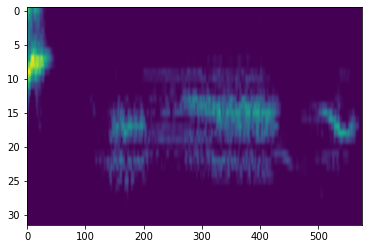

In [23]:
# example syllable for visualization
i_syl = 11
plt.imshow(syl_df.iloc[i_syl]['spec'][::-1], aspect='auto')

### Pad spectrogams

In [24]:
all_syl_len = [s.shape[-1] for s in syl_df['spec']]
pad_len = np.max(all_syl_len)

syl_df['spec_pad'] = syl_df['spec'].apply(lambda x: pad_spectrogram(x, pad_len))

In [ ]:
# plot padded syllable
plt.imshow(syl_df.iloc[i_syl]['spec_pad'][::-1], aspect='auto')

In [27]:
# spk_pad_len = np.max(list(map(lambda x: x.shape[-1], syl_df['spk_ms_arr'])))
# spk_pad_len

# syl_df['spk_pad'] = syl_df['spk_ms_arr'].apply(lambda x: pad_spectrogram(x, spk_pad_len))

In [28]:
#spk_pad = pad_spectrogram(syl_df.iloc[i_syl]['spk_ms_arr'], spk_pad_len)

In [29]:
syl_df['spec_pad'] = syl_df['spec_pad'].apply(lambda x: (norm(x)*255).astype('uint8'))

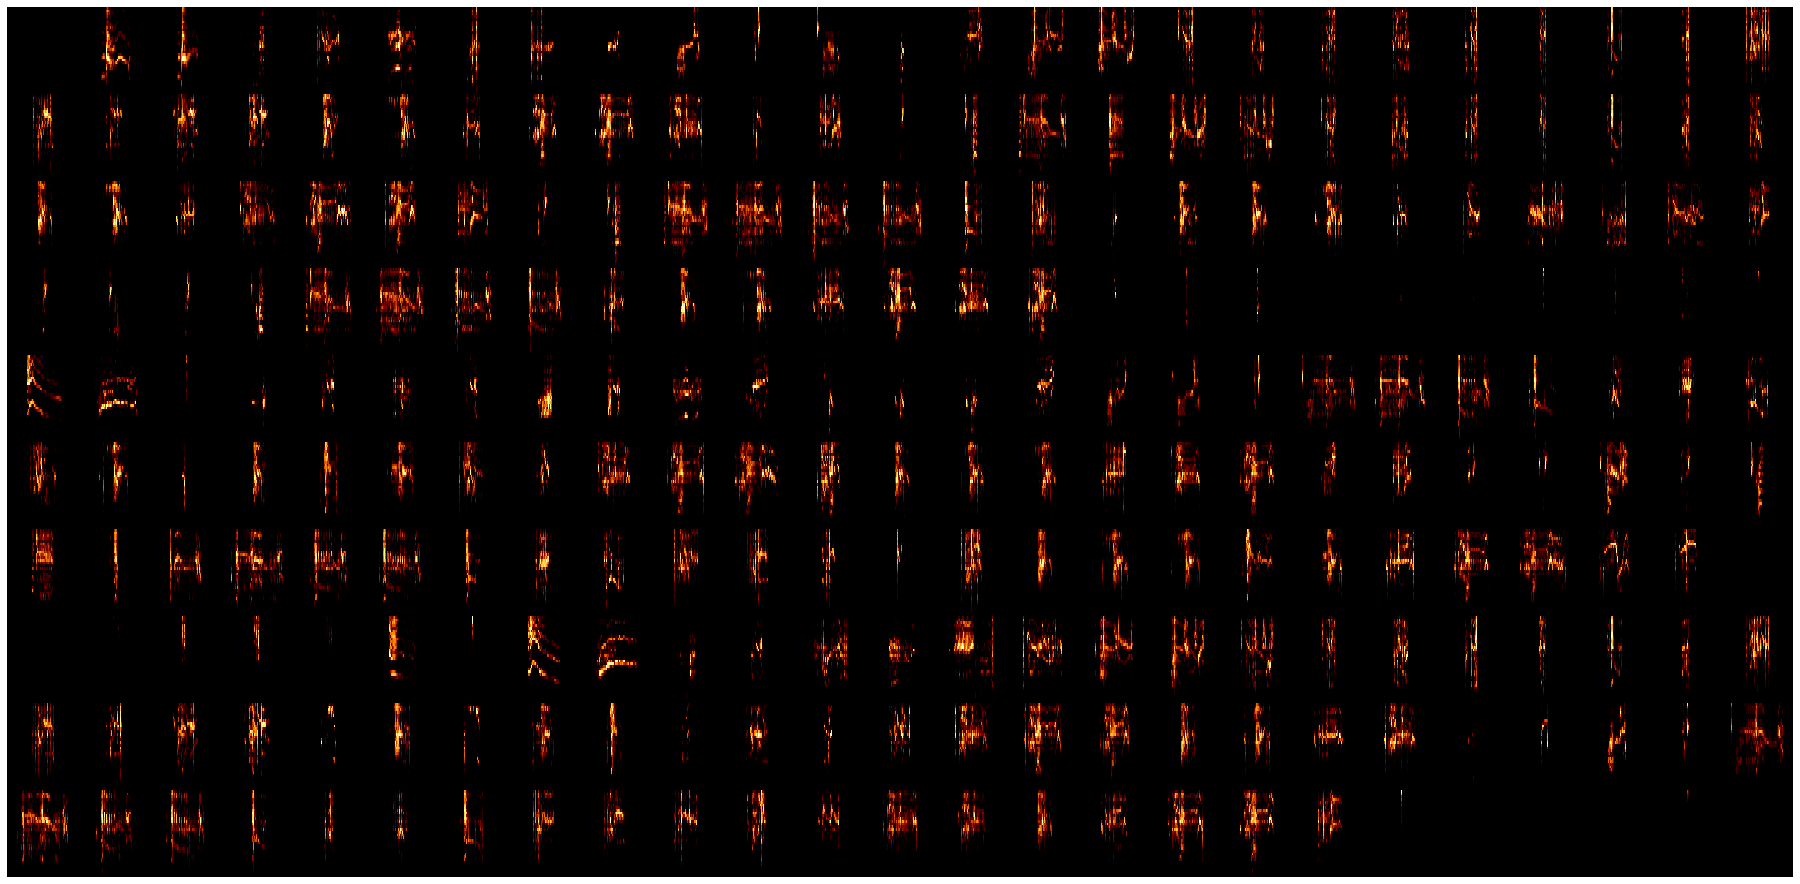

In [30]:
fig, ax = plt.subplots(figsize=(32, 16))

draw_spec_set(list(syl_df['spec_pad']), zoom=20, maxrows=10, colsize=25, ax=ax)

### Cluster spectrograms with hdbscan
Get umap embeddings of all padded syllables

In [31]:
embedding = umap.UMAP(min_dist = 0.5, verbose = True)

specs_flattened = flatten_spectrograms(list(syl_df['spec_pad']))
specs_umap = list(embedding.fit_transform(specs_flattened))
syl_df['umap'] = specs_umap

UMAP(min_dist=0.5, verbose=True)
Fri Aug 25 13:31:03 2023 Construct fuzzy simplicial set
Fri Aug 25 13:32:04 2023 Finding Nearest Neighbors
Fri Aug 25 13:32:06 2023 Finished Nearest Neighbor Search
Fri Aug 25 13:32:08 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Aug 25 13:32:15 2023 Finished embedding


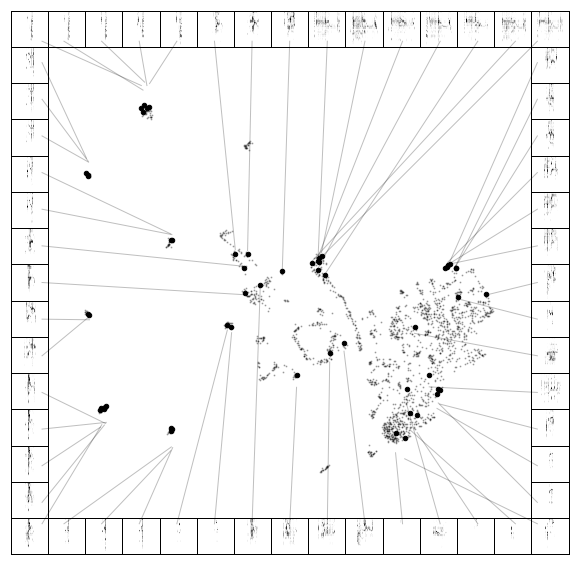

In [33]:
scatter_spec(
        np.vstack(syl_df['umap']),
        list(syl_df['spec_pad']),
        column_size=15,
        #x_range = [-5.5,7],
        #y_range = [-10,10],
        pal_color="hls",
        color_points=False,
        enlarge_points=20,
        figsize=(10, 10),
        scatter_kwargs = {
            #'labels': list(indv_df.phrase.values),
            'alpha':0.25,
            's': 1,
            'show_legend': False
        },
        matshow_kwargs = {
            'cmap': plt.cm.Greys
        },
        line_kwargs = {
            'lw':1,
            'ls':"solid",
            'alpha':0.25,
        },
        draw_lines=True
    );

plt.show()

cluster all padded

In [34]:
umap_arr = np.vstack(list(syl_df['umap']))

min_cluster_size = int(len(umap_arr) * 0.002) # 0.002
print(min_cluster_size)

4


In [35]:
clusterer = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size).fit(umap_arr)

syl_df['hdbscan_labels'] = list(clusterer.labels_)

/mnt/cube/earneodo/repos/txori/avgn_paper/avgn/visualization/projections.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  colors = np.array([lab_dict[i] for i in labels])


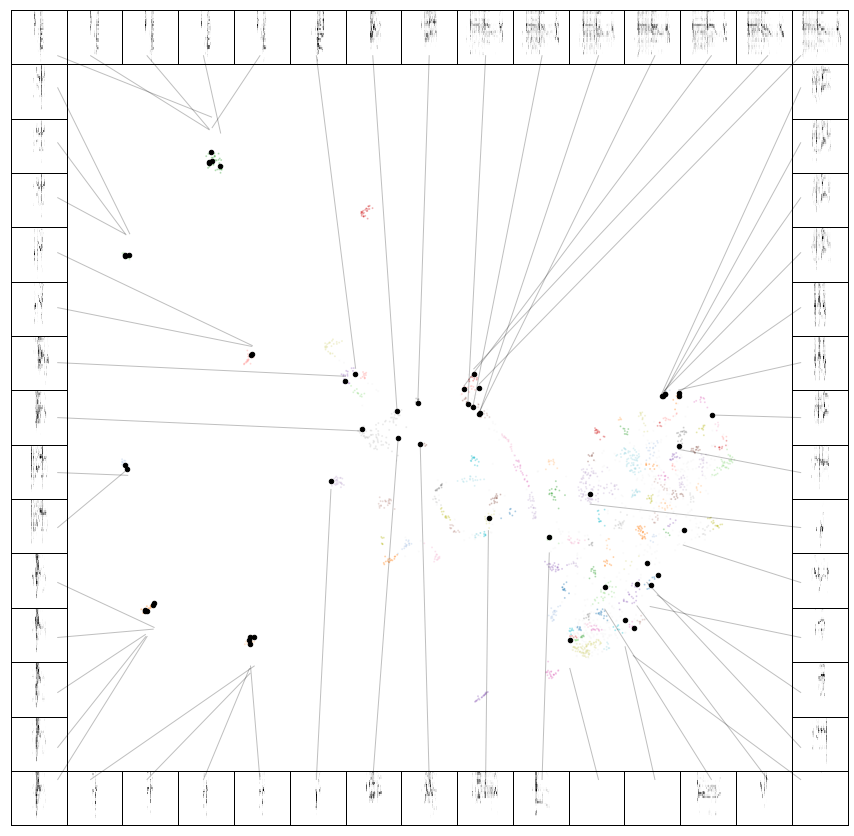

In [36]:
scatter_spec(
        umap_arr,
        list(syl_df['spec_pad']),
        column_size=15,
        #x_range = [-5.5,7],
        #y_range = [-10,10],
        pal_color="hls",
        color_points=False,
        enlarge_points=20,
        figsize=(15, 15),
        scatter_kwargs = {
            'labels': list(syl_df.hdbscan_labels.values),
            'alpha':0.25,
            's': 1,
            'show_legend': False
        },
        matshow_kwargs = {
            'cmap': plt.cm.Greys
        },
        line_kwargs = {
            'lw':1,
            'ls':"solid",
            'alpha':0.25,
        },
        draw_lines=True
    );
plt.show()

In [37]:
syl_df.head(1)

,syl_idx,mic_arr,s_on,s_on_gpf,gpf_arr,pre_arr,spk_ms_arr,spk_arr,bout_idx,spec,spec_pad,pre_pad,gpf_pad,umap,hdbscan_labels
0,0-0,"[2, 3, 11, 4, -1, 13, 32, -8, 15, -4, 18, 11, ...",189640,316,"[[-0.7721941002898705, -0.654150502280424, -0....","[10913, 10921, 10909, 10908, 10926, 10917, 109...",NaN,NaN,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[24.747936, 0.21715425]",-1


In [38]:
np.unique(syl_df['hdbscan_labels'])

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111])

In [39]:
syl_sel = (syl_df['hdbscan_labels']==11)
np.sum(syl_sel==True)

23

### Save outputs

In [18]:
# syl_df_file = output_path + 'syl_clust_df.pkl'
# syl_df_file

In [44]:
# with open(syl_df_file, 'wb') as f:
#     pickle.dump(syl_df, f)

In [45]:
# with open(syl_df_file, 'rb') as f:
#     syl_df = pickle.load(f) 